In [7]:
# imports
import os
import sys
import time
import copy
# add to the path the source files
sys.path.append(os.path.dirname(os.getcwd()))

import wandb
import numpy as np
import pandas as pd
from copy import deepcopy
from dgl.data.utils import load_graphs
import dgl
import torch 
import torch.nn as nn
import torch_geometric 
from torch_geometric.loader import DataLoader
import networkx as nx
from src.dataset.counting_algorithm import subgraph_counting
#from src.baseline.model_gcn import GCN, GIN
from src.baseline.dataset_gcn import GraphDataset
from src.metrics.L1_based import L1LossCount, L1LossStd
from matplotlib import pyplot as plt
from src.baseline.model_gcn import GCN, GIN
import random

def train_epoch(gin, dataloader, loss_fn, optimizer, device):
    gin.train()
    tot_loss = 0.
    for data, y in dataloader:
        #print(len(data.batch.unique()))
        optimizer.zero_grad()
        data = data.to(device)
        y = y.to(device)
        
        pred = gin(data).flatten()
        loss = loss_fn(pred, y)
        tot_loss += loss
      
        loss.backward()
        optimizer.step()
    #return tot_loss/len(dataloader)

def eval_epoch(gin, dataloader, loss_fn, device):
    gin.eval()
    with torch.no_grad():
        loss = 0.
        for data, y in dataloader:
            #print(len(data.batch.unique()))
            data = data.to(device)
            y = y.to(device)

            pred = gin(data).flatten()
            l = loss_fn(pred, y)
            loss += l
            
        loss = loss / len(dataloader)
    return loss


def generate_gnn_input(graph: nx.Graph, device)->torch_geometric.data.Data:
    """Creates from a networkx graph a Data instance, which is the input a a pytorch geometric model."""
    x = torch.ones(graph.number_of_nodes(), 1) # no improovement by using more channels in the first layer
    edge_index = torch.empty(2, graph.number_of_edges(), dtype=torch.long)
    for i, edge in enumerate(graph.edges()):
        edge_index[0,i] = edge[0]
        edge_index[1,i] = edge[1]
    return torch_geometric.data.Data(x=x, edge_index=edge_index).to(device)

loss_fn = torch.nn.L1Loss()
budget = 5
n_samples = 100
random.seed(1234)
np.random.seed(1234)

,Graph,Model,Count,Adversarial_count,Base error,Adversarial error,Base prediction,Adversarial prediction,Steps
0,0,0,19.0,9,5.785538,16.02025,24.785538,25.02025,5
1,0,1,19.0,9,4.75771,15.036427,22.552448,24.036423,5
2,0,2,19.0,9,5.985588,16.489822,23.921778,25.489824,5
3,0,3,19.0,10,4.253122,15.489529,23.666655,25.489529,5
4,0,4,19.0,36,2.100998,19.834688,19.186491,16.165312,5
5,1.0,0.0,25.0,43.0,0.922146,19.536577,24.785538,23.463423,5.0
6,1.0,1.0,25.0,43.0,2.447552,21.27426,22.552448,21.72574,5.0
7,1.0,2.0,25.0,42.0,1.027504,18.94281,23.921778,23.057188,5.0
8,1.0,3.0,25.0,40.0,4.598421,26.519127,23.666655,13.480872,5.0
9,1.0,4.0,25.0,43.0,8.909279,28.041723,19.186491,14.958277,5.0


19.797983016967773


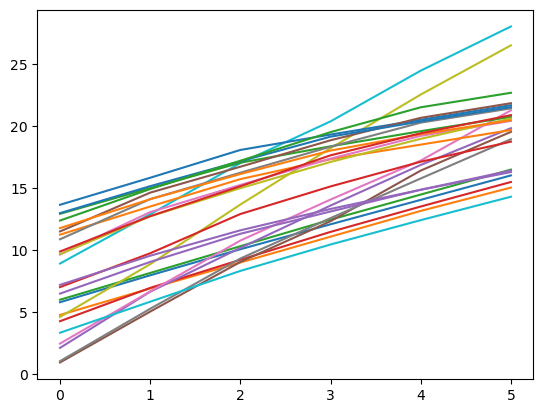

In [16]:
# robustness greedy
from src.adversarial.greedy_attack import GreedyAttack

from joblib import Parallel, delayed

task = 'g31'
device = 'cpu'
dataset_path = "/home/francesco/Desktop/Master thesis/robustness-of-subgraphs-count/data/robustness/robustness_5_er_50.bin"
models_path = [f"/home/francesco/Desktop/Master thesis/robustness-of-subgraphs-count/models/GIN/GIN_g31_{i}.pkl" for i in range(5)]
gnns = [torch.load(path, map_location=torch.device(device)).to(device) for path in models_path]
graphs, counts = dgl.load_graphs(dataset_path)

greedy_attack = GreedyAttack(budget=budget, edge_addition=True, edge_deletion=True, device=device)
results = pd.DataFrame(columns=["Graph", "Model", "Count", "Adversarial_count", "Base error", "Adversarial error", "Base prediction", "Adversarial prediction", "Steps"], index=list(range(len(graphs))))

for j in range(len(graphs)):
    graph = nx.Graph(dgl.to_networkx(graphs[j]))
    count = counts[task][j]
    result = Parallel(n_jobs=5)(delayed(greedy_attack.find_adversarial_example)(gnn=gnn, loss_fn=loss_fn, graph=graph,subgraph_type=task,count=count) for gnn in gnns)
    adversarial_errors = torch.empty((len(gnns), len(gnns)))
    for i in range(len(result)): 
        adversarial_graph = result[i][0]
        adversarial_error_history = result[i][1]
        gnn = gnns[i]
        graph = nx.Graph(dgl.to_networkx(graphs[i]))
        with torch.no_grad():
            pred = gnn(generate_gnn_input(graph, device)).flatten().item()
            adversarial_pred = gnn(generate_gnn_input(adversarial_graph, device)).flatten().item()
        plt.plot(list(range(len(adversarial_error_history))), adversarial_error_history)
        adversarial_count = subgraph_counting(graph=adversarial_graph, subgraph_type=task)
        results.loc[j*len(gnns) + i] = [j, i, count.item(), adversarial_count, adversarial_error_history[0], adversarial_error_history[-1], pred, adversarial_pred, len(adversarial_error_history)-1]
        adversarial_errors[i,i] = adversarial_error_history[-1]
        for k in range(len(gnns)):
            if k != i:
                adversarial_errors[i,k] = loss_fn(gnns[k](generate_gnn_input(adversarial_graph, device)).flatten(), torch.tensor([adversarial_count]))
display(results)
print(results["Adversarial error"].mean())
#print(adversarial_errors)
plt.show()



,Graph,Model,Count,Adversarial_count,Base error,Adversarial error,Base prediction,Adversarial prediction,Steps
0,0,0,19.0,14,5.785538,11.492172,24.785538,25.492172,5
1,0,1,19.0,11,4.75771,13.013483,22.552448,24.013481,5
2,0,2,19.0,13,5.985588,12.75626,23.921778,25.75626,5
3,0,3,19.0,13,4.253122,12.642838,23.666655,25.642839,5
4,0,4,19.0,27,2.100998,11.336339,19.186491,15.663661,5
5,1,0,25.0,32,0.922146,8.405409,24.785538,23.594591,5
6,1,1,25.0,35,2.447552,12.872892,22.552448,22.127108,5
7,1,2,25.0,31,1.027504,7.928553,23.921778,23.071445,5
8,1,3,25.0,29,4.598421,16.863621,23.666655,12.136383,5
9,1,4,25.0,34,8.909279,18.485569,19.186491,15.514431,5


15.08702579498291


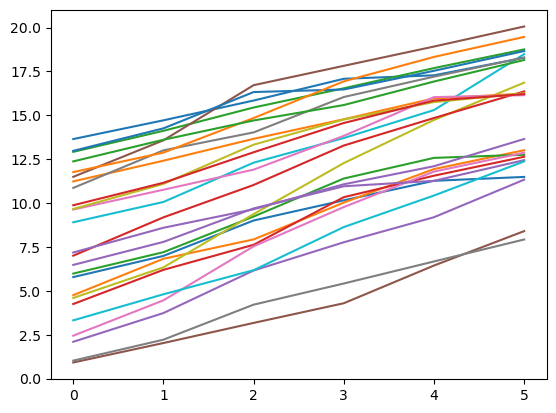

In [23]:
# robustness greedy
from src.adversarial.greedy_attack import RandomGreedyAttack

from joblib import Parallel, delayed

task = 'g31'
device = 'cpu'
dataset_path = "/home/francesco/Desktop/Master thesis/robustness-of-subgraphs-count/data/robustness/robustness_5_er_50.bin"
models_path = [f"/home/francesco/Desktop/Master thesis/robustness-of-subgraphs-count/models/GIN/GIN_g31_{i}.pkl" for i in range(5)]
gnns = [torch.load(path, map_location=torch.device(device)).to(device) for path in models_path]
graphs, counts = dgl.load_graphs(dataset_path)

greedy_attack = RandomGreedyAttack(budget=budget, n_samples = n_samples, edge_addition=True, edge_deletion=True, device=device)
results = pd.DataFrame(columns=["Graph", "Model", "Count", "Adversarial_count", "Base error", "Adversarial error", "Base prediction", "Adversarial prediction", "Steps"], index=list(range(len(graphs)*len(gnns))))

for j in range(len(graphs)):
    graph = nx.Graph(dgl.to_networkx(graphs[j]))
    count = counts[task][j]
    result = Parallel(n_jobs=5)(delayed(greedy_attack.find_adversarial_example)(gnn=gnn, loss_fn=loss_fn, graph=graph,subgraph_type=task,count=count) for gnn in gnns)
    adversarial_errors = torch.empty((len(gnns), len(gnns)))
    for i in range(len(result)): 
        adversarial_graph = result[i][0]
        adversarial_error_history = result[i][1]
        gnn = gnns[i]
        graph = nx.Graph(dgl.to_networkx(graphs[i]))
        with torch.no_grad():
            pred = gnn(generate_gnn_input(graph, device)).flatten().item()
            adversarial_pred = gnn(generate_gnn_input(adversarial_graph, device)).flatten().item()
        plt.plot(list(range(len(adversarial_error_history))), adversarial_error_history)
        adversarial_count = subgraph_counting(graph=adversarial_graph, subgraph_type=task)
        results.loc[j*len(gnns) + i] = [j, i, count.item(), adversarial_count, adversarial_error_history[0], adversarial_error_history[-1], pred, adversarial_pred, len(adversarial_error_history)-1]
        adversarial_errors[i,i] = adversarial_error_history[-1]
        for k in range(len(gnns)):
            if k != i:
                adversarial_errors[i,k] = loss_fn(gnns[k](generate_gnn_input(adversarial_graph, device)).flatten(), torch.tensor([adversarial_count]))
display(results)
print(results["Adversarial error"].mean())
#print(adversarial_errors)
plt.show()



hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi


,Graph,Model,Count,Adversarial_count,Base error,Adversarial error,Base prediction,Adversarial prediction,Steps
0,0,0,19.0,9,5.785538,16.02025,24.785538,25.02025,5
1,0,1,19.0,9,4.75771,15.036427,22.552448,24.036423,5
2,0,2,19.0,9,5.985588,16.489822,23.921778,25.489824,5
3,0,3,19.0,10,4.253122,15.489529,23.666655,25.489529,5
4,0,4,19.0,35,2.100998,19.019997,19.186491,15.980003,5
5,1.0,0.0,25.0,41.0,0.922146,17.556999,24.785538,23.443003,5.0
6,1.0,1.0,25.0,41.0,2.447552,19.219378,22.552448,21.780624,5.0
7,1.0,2.0,25.0,40.0,1.027504,16.966444,23.921778,23.033556,5.0
8,1.0,3.0,25.0,39.0,4.598421,24.720907,23.666655,14.279091,5.0
9,1.0,4.0,25.0,42.0,8.909279,27.202555,19.186491,14.797445,5.0


19.378402481079103


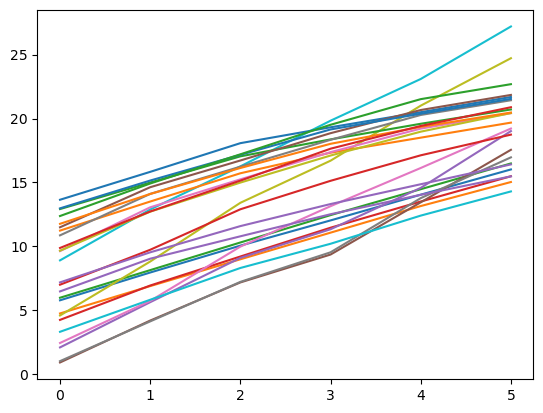

In [5]:
# robustness greedy
from src.adversarial.greedy_attack import RandomProbGreedyAttack

from joblib import Parallel, delayed
start = time.time()
task = 'g31'
device = 'cpu'
dataset_path = "/home/francesco/Desktop/Master thesis/robustness-of-subgraphs-count/data/robustness/robustness_5_er_50.bin"
models_path = [f"/home/francesco/Desktop/Master thesis/robustness-of-subgraphs-count/models/GIN/GIN_g31_{i}.pkl" for i in range(5)]
gnns = [torch.load(path, map_location=torch.device(device)).to(device) for path in models_path]
graphs, counts = dgl.load_graphs(dataset_path)

greedy_attack = RandomProbGreedyAttack(budget=budget, n_samples= n_samples, edge_addition=True, edge_deletion=True, device=device)
results = pd.DataFrame(columns=["Graph", "Model", "Count", "Adversarial_count", "Base error", "Adversarial error", "Base prediction", "Adversarial prediction", "Steps"], index=list(range(len(graphs))))

for j in range(len(graphs)):
    graph = nx.Graph(dgl.to_networkx(graphs[j]))
    count = counts[task][j]
    result = Parallel(n_jobs=5)(delayed(greedy_attack.find_adversarial_example)(gnn=gnn, loss_fn=loss_fn, graph=graph,subgraph_type=task,count=count) for gnn in gnns)
    adversarial_errors = torch.empty((len(gnns), len(gnns)))
    for i in range(len(result)): 
        adversarial_graph = result[i][0]
        adversarial_error_history = result[i][1]
        gnn = gnns[i]
        graph = nx.Graph(dgl.to_networkx(graphs[i]))
        with torch.no_grad():
            pred = gnn(generate_gnn_input(graph, device)).flatten().item()
            adversarial_pred = gnn(generate_gnn_input(adversarial_graph, device)).flatten().item()
        plt.plot(list(range(len(adversarial_error_history))), adversarial_error_history)
        adversarial_count = subgraph_counting(graph=adversarial_graph, subgraph_type=task)
        results.loc[j*len(gnns) + i] = [j, i, count.item(), adversarial_count, adversarial_error_history[0], adversarial_error_history[-1], pred, adversarial_pred, len(adversarial_error_history)-1]
        adversarial_errors[i,i] = adversarial_error_history[-1]
        for k in range(len(gnns)):
            if k != i:
                adversarial_errors[i,k] = loss_fn(gnns[k](generate_gnn_input(adversarial_graph, device)).flatten(), torch.tensor([adversarial_count]).to(device))
display(results)
print(results["Adversarial error"].mean())
#print(adversarial_errors)
plt.show()



## adversarial training

As we have analysed the adversarial attack with random selection and atom probabilites prop to the degree can yield comparable results with computational complexity constant wrt  the number of nodes. Hence we try to take advantage of it to use it in the training od the network. Namely, every m epochs we select a few graphs from the dataset and substiutute them with an adversarial example generated from them.

In [8]:
device = 'cuda'
pre_training = 20 # epochs used to pretrain the model
n_epochs = 30
interval_epoches = 10
n_adv_examples = 20
batch_size = 128
task = 's3'
lr = 1e-2

train_dataset = GraphDataset(dataset_path="/home/francesco/Desktop/Master thesis/robustness-of-subgraphs-count/data/training/train_10000_er_50.bin", task=task, in_channels=1)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
val_dataset = GraphDataset(dataset_path="/home/francesco/Desktop/Master thesis/robustness-of-subgraphs-count/data/training/validation_10000_er_50.bin", task=task, in_channels=1)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
h_params = {
    'in_channels': 1, 'hidden_channels': 64, 'out_channels': 32, 'num_layers': 3, 'pooling':'add',  'concat': True
}
gnn = GIN(**h_params).to(device)
adverarial_attack = RandomProbGreedyAttack(budget=2, n_samples=100, edge_addition=True, edge_deletion=True, device=device)
loss_fn = torch.nn.L1Loss()
optimizer = torch.optim.Adam(params=gnn.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor = 5e-1, patience=20)

# pre_training
for i in range(pre_training):
    train_epoch(gnn, train_dataloader, loss_fn,  optimizer, device)
    train_loss = eval_epoch(gnn, train_dataloader, loss_fn, device)
    val_loss = eval_epoch(gnn, val_dataloader, loss_fn, device)
    scheduler.step(val_loss)
    print(f'Epoch: {i}: train loss {train_loss}, val loss {val_loss}')
print('End of pretraining!')

# adversarial training
for i in range(n_epochs):
    if i % interval_epoches == 0: # update the adversarial examples
        print(f'generated adversarial examples...')
        train_dataset_adv = copy.deepcopy(train_dataset)
        samples = random.sample(list(range(len(train_dataset_adv))), n_adv_examples)
        adv_examples  = Parallel(n_jobs=10)(delayed(greedy_attack.find_adversarial_example)(
            gnn=gnn, 
            loss_fn=loss_fn, 
            graph=nx.Graph(torch_geometric.utils.to_dense_adj(train_dataset_adv.data[i].edge_index)),
            subgraph_type=task,
            count=train_dataset_adv.labels[j])
            for j in samples
        )
        # insert the new graphs in the dataset
        for (adv_graph, _, adv_count), j in zip(adv_examples, samples):
            train_dataset_adv.data[j] = generate_gnn_input(adv_graph, device)
            train_dataset_adv.labels[j] = adv_count
        train_dataloader_adv = DataLoader(train_dataset_adv, batch_size)
    train_epoch(gnn, train_dataloader, loss_fn,  optimizer, device)
    train_loss = eval_epoch(gnn, train_dataloader, loss_fn, device)
    val_loss = eval_epoch(gnn, val_dataloader, loss_fn, device)
    scheduler.step(val_loss)
    print(f'Epoch: {i}: train loss {train_loss}, val loss {val_loss}')
    


Epoch: 0: train loss 129.83370971679688, val loss 132.94007873535156
Epoch: 1: train loss 95.41513061523438, val loss 98.54151153564453
Epoch: 2: train loss 231.16441345214844, val loss 233.91702270507812
Epoch: 3: train loss 59.435829162597656, val loss 60.60698318481445
Epoch: 4: train loss 272.27606201171875, val loss 276.86328125
Epoch: 5: train loss 99.36234283447266, val loss 100.472900390625
Epoch: 6: train loss 103.16472625732422, val loss 104.48242950439453
Epoch: 7: train loss 53.1765022277832, val loss 52.35979461669922
Epoch: 8: train loss 39.24970626831055, val loss 38.3053092956543
Epoch: 9: train loss 67.21736145019531, val loss 69.27180480957031
Epoch: 10: train loss 137.3984375, val loss 140.3888702392578
Epoch: 11: train loss 36.98229217529297, val loss 37.43567657470703
Epoch: 12: train loss 92.55426025390625, val loss 95.21588897705078
Epoch: 13: train loss 46.17574691772461, val loss 45.24095916748047
Epoch: 14: train loss 43.99755096435547, val loss 45.26574325561

NetworkXError: Input is not a valid edge list